### Test greediness of Ipsen perturbation bound Sparse PCA

Guess the Sparse PCA solution, then multiply through by the original matrix of observations to create a "pseudo left singular vector" U. Now, if we had a change-of-basis of the observations, then the loading along the basis vector U should be the most important dimension to consider. First project the variables onto U (take a multiple of e_1 in the new basis). Then the Sparse PCA heuristic should be somewhat greedy about the squared magnitude. However, also zero out this first dimension and compute a new residual covariance matrix, which we still need (it is not a greedy algorithm). Use the spectral radius of Sigma_U (rank-one covariance matrix) and the matrix-vector multiplication of Sigma_residual (via Ipsen et al):

|| Sigma_U || + || Sigma_residual * V ||

Where V is a right-singular vector corresponding to the left-singular vector U.

|| Sigma_U || should be the larger term if the initial heuristic was good. Variables are selected using a zero-one vector z: {0,1}^n

sum_i z_i * <x_i, U>^2 + || Diag(z) Sigma_residual Diag(z) V || / || Diag(z) V ||

In this notebook, we simply want to plot one of the optimal solutions which we found, and see whether <x_i, U> strongly influences whether the variable is optimal, or maybe whether variables can be discarded early.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth = 150, precision = 4, suppress = True)

In [32]:

# Covariance matrix.
data = np.loadtxt('../NC-Data.csv', delimiter=',', dtype=str)
data = data[1:].astype(float)
# Synthesize columns holding observations, reproducing the cov matrix.
raw_data = np.linalg.cholesky(data).T
np.testing.assert_allclose(data, raw_data.T @ raw_data)
data

array([[ 1.    , -0.0461,  0.2312, ...,  0.2704,  0.4664,  0.3672],
       [-0.0461,  1.    , -0.0671, ..., -0.0515, -0.0944, -0.0349],
       [ 0.2312, -0.0671,  1.    , ...,  0.147 ,  0.2608,  0.6313],
       ...,
       [ 0.2704, -0.0515,  0.147 , ...,  1.    ,  0.2066,  0.1538],
       [ 0.4664, -0.0944,  0.2608, ...,  0.2066,  1.    ,  0.3486],
       [ 0.3672, -0.0349,  0.6313, ...,  0.1538,  0.3486,  1.    ]])

In [34]:
# Output traced from Julia program. The node is in {-1,0,1}^n
# and we are particularly interested in selected 1 values (the
# variable at index i must be included in the solution).
nodes = np.loadtxt('../NC-K7-Trace-Nodes.csv', delimiter=',', dtype=str)
nodes = nodes[1:].astype(float)

In [36]:
# Pick the first node visited where 3 variables have the indicator variable set to 1.
np.argmax((nodes == 1).sum(axis=0) == 3)

42

In [37]:
selected = np.where(nodes[:, 42] == 1)[0]
selected

array([ 3, 83, 85])

In [39]:
# opt_inds determined in a separate brute-force script for the selected node.
# Using selected and opt_inds is the Sparse PCA solution for k = 7.
opt_inds = [79, 80, 81, 84]

In [40]:
# Left singular vector with the greatest singular value. For this
# demo, we will work with raw_data. The alternative is doing most
# of the computations on the symmetric eigensystem (probably
# preferable), and multiplying through by raw_data once, then
# dividing by L2 norm, to calculate U.
U = np.linalg.svd(raw_data[:, selected], full_matrices=0)[0][:, 0]
# Inner products of the observations x with the left singular vector U.
XU = raw_data.T @ U

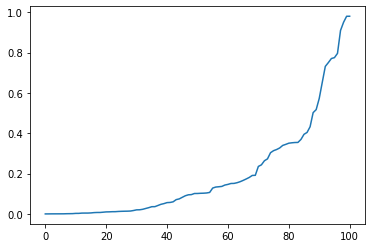

In [41]:
# Is U a good pseudo-singular vector? Do we have >>k variables
# which all would have a large loading along the basis vector U,
# so the k variables probably have good correlation with each
# other? Note that the correlation between variables is not
# captured by this plot. At 1.0, correlation would also be 1.0,
# but maybe there are not k variables exactly at a value of 1.0
# and we move down the list substantially to find k variables
# all with strong correlation with each other.
plt.plot(np.sort(XU ** 2))

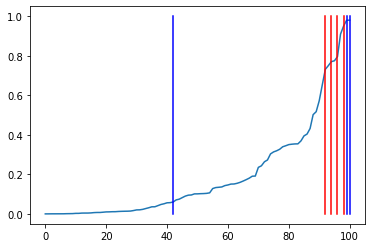

In [42]:
select_variables = np.argsort(XU ** 2)
select_variables_inverse = np.argsort(select_variables)
plt.plot(XU[select_variables] ** 2)
for loc in selected:
    loc = select_variables_inverse[loc]
    plt.plot([loc, loc], [0, 1], 'blue')
for loc in opt_inds:
    loc = select_variables_inverse[loc]
    plt.plot([loc, loc], [0, 1], 'red')